In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots,
    grid_search_best_params
)

In [3]:
merged_df_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(merged_df_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [4]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

In [5]:
merged_df.columns

Index(['index', 'geonameid', 'name_x', 'asciiname', 'latitude', 'longitude',
       'iso alpha 2', 'City', 'Geonames ID', 'Country',
       'Residential EUI (kWh/m2/year)', 'Non-residential EUI (kWh/m2/year)',
       'source', 'ISO_alpha3', 'Population_2023', 'population_density',
       'Subnational HDI', 'Educational index', 'Income index', 'GDP_2022',
       'Urbanization_Rate_2022', 'Paris_Agreement', 'iso3', 'name_y',
       'continent', 'region', 'Region Grouped', 'hdd_total_year',
       'hdd_average_year', 'hdd_variance_year', 'cdd_total_year',
       'cdd_average_year', 'cdd_variance_year', '2m_temperature_2023_avg',
       '2m_dewpoint_temperature_2023_avg', 'total_precipitation_2023',
       'longitude_sin', 'longitude_cos', 'latitude_sin', 'latitude_cos',
       'pca_result', 'K_mean_label', 'C_mean_label', 'GMM_label', 'K_mean_0',
       'K_mean_1', 'K_mean_2', 'K_mean_3', 'K_mean_4', 'K_mean_5', 'K_mean_6',
       'K_mean_7', 'K_mean_8', 'K_mean_9', 'K_mean_10', 'K_mean_1

In [6]:
features = [
    "hdd_total_year", 
    #"cdd_total_year", 
    #"GDP_per_capita", 
    #"Urbanization_Rate_2022",
    #"latitude",
    #"longitude",  
    #"Paris_Agreement",
    "Subnational HDI", 
    #"Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    #"total_precipitation_2023",
    #"longitude_sin", 
    "longitude_cos", 
    "latitude_sin", 
    "latitude_cos",  
    #"population_density",

    #Image data
 
    #'pca_result', 
    #'K_mean_label', 
    #'C_mean_label', 
    #'GMM_label', 
    #'pca_result', 
    #'K_mean_0', 
    #'K_mean_1', 
    #'K_mean_2', 
    #'K_mean_3', 
    #'K_mean_4', 
    #'K_mean_5', 
    #'K_mean_6', 
    #'K_mean_7', 
    #'K_mean_8', 
    #'K_mean_9', 
    #'K_mean_10', 
    #'K_mean_11', 
    #'K_mean_12', 
    #'K_mean_13', 
    #'K_mean_14', 
    #'K_mean_15', 
    #'K_mean_16', 
    #'K_mean_17', 
    #'K_mean_18', 
    #'K_mean_19', 
    #'C_mean_0', 
    #'C_mean_1', 
    #'C_mean_2', 
    #'C_mean_6', 
    #'C_mean_7', 
    #'C_mean_8', 
    #'C_mean_14', 
    #'C_mean_17', 
    #'GMM_0', 
    #'GMM_1', 
    #'GMM_2', 
    #'GMM_3', 
    #'GMM_4', 
    #'GMM_5', 
    #'GMM_6', 
    #'GMM_7', 
    #'GMM_8', 
    #'GMM_9', 
    #'GMM_10', 
    #'GMM_11', 
    #'GMM_12', 
    #'GMM_13', 
    #'GMM_14', 
    #'GMM_15', 
    #'GMM_16', 
    #'GMM_17', 
    #'GMM_18', 
    #'GMM_19', 
    ]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
   # "latitude": "Lat",
   # "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    "total_precipitation_2023": "Precip",
    "longitude_sin": "Long_Sin", 
    "longitude_cos": "Long_Cos", 
    "latitude_sin": "Lat_Sin", 
    "latitude_cos": "Lat_Cos",  
    "population_density": "Pop_Dens",

    #Image data
    #'pca_result': 'pca_result',
    #'K_mean_label': 'K_mean_label',
    #'C_mean_label': 'C_mean_label',
    #'GMM_label': 'GMM_label',
    #'K_mean_0': 'K_mean_0',
    #'K_mean_1': 'K_mean_1',
    #'K_mean_2': 'K_mean_2',
    #'K_mean_3': 'K_mean_3',
    #'K_mean_4': 'K_mean_4',
    #'K_mean_5': 'K_mean_5',
    #'K_mean_6': 'K_mean_6',
    #'K_mean_7': 'K_mean_7',
    #'K_mean_8': 'K_mean_8',
    #'K_mean_9': 'K_mean_9',
    #'K_mean_10': 'K_mean_10',
    #'K_mean_11': 'K_mean_11',
    #'K_mean_12': 'K_mean_12',
    #'K_mean_13': 'K_mean_13',
    #'K_mean_14': 'K_mean_14',
    #'K_mean_15': 'K_mean_15',
    #'K_mean_16': 'K_mean_16',
    #'K_mean_17': 'K_mean_17',
    #'K_mean_18': 'K_mean_18',
    #'K_mean_19': 'K_mean_19',
    #'C_mean_0': 'C_mean_0',
    #'C_mean_1': 'C_mean_1',
    #'C_mean_2': 'C_mean_2',
    #'C_mean_6': 'C_mean_6',
    #'C_mean_7': 'C_mean_7',
    #'C_mean_8': 'C_mean_8',
    #'C_mean_14': 'C_mean_14',
    #'C_mean_17': 'C_mean_17',
    #'GMM_0': 'GMM_0',
    #'GMM_1': 'GMM_1',
    #'GMM_2': 'GMM_2',
    #'GMM_3': 'GMM_3',
    #'GMM_4': 'GMM_4',
    #'GMM_5': 'GMM_5',
    #'GMM_6': 'GMM_6',
    #'GMM_7': 'GMM_7',
    #'GMM_8': 'GMM_8',
    #'GMM_9': 'GMM_9',
    #'GMM_10': 'GMM_10',
    #'GMM_11': 'GMM_11',
    #'GMM_12': 'GMM_12',
    #'GMM_13': 'GMM_13',
    #'GMM_14': 'GMM_14',
    #'GMM_15': 'GMM_15',
    #'GMM_16': 'GMM_16',
    #'GMM_17': 'GMM_17',
    #'GMM_18': 'GMM_18',
    #'GMM_19': 'GMM_19'
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# Random Forest
# Grid Serach

In [7]:
# Define parameter grid for RandomForestRegressor
'''
rf_param_grid = {
    'n_estimators': [100, 500, 1200],
    'max_depth': [None, 10,  20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42],
    'n_jobs': [-1]
}

# Run grid search with cross-validation
best_params, best_score = grid_search_best_params(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_class=RandomForestRegressor,
    param_grid=rf_param_grid,
    feature_abbreviations=feature_abbreviations
)'
'''

"\nrf_param_grid = {\n    'n_estimators': [100, 500, 1200],\n    'max_depth': [None, 10,  20],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 3, 5],\n    'max_features': ['sqrt', 'log2'],\n    'bootstrap': [True, False],\n    'random_state': [42],\n    'n_jobs': [-1]\n}\n\n# Run grid search with cross-validation\nbest_params, best_score = grid_search_best_params(\n    merged_df=merged_df,\n    regions=regions,\n    features=features,\n    model_class=RandomForestRegressor,\n    param_grid=rf_param_grid,\n    feature_abbreviations=feature_abbreviations\n)'\n"

In [8]:
# Random Forest parameters

rf_params = {
    'n_estimators': 10,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',   
    'bootstrap': False,      
    'random_state': 42,
    'n_jobs': -1 ,
    'criterion': 'absolute_error'        
}

### Random Forest - Within Domain

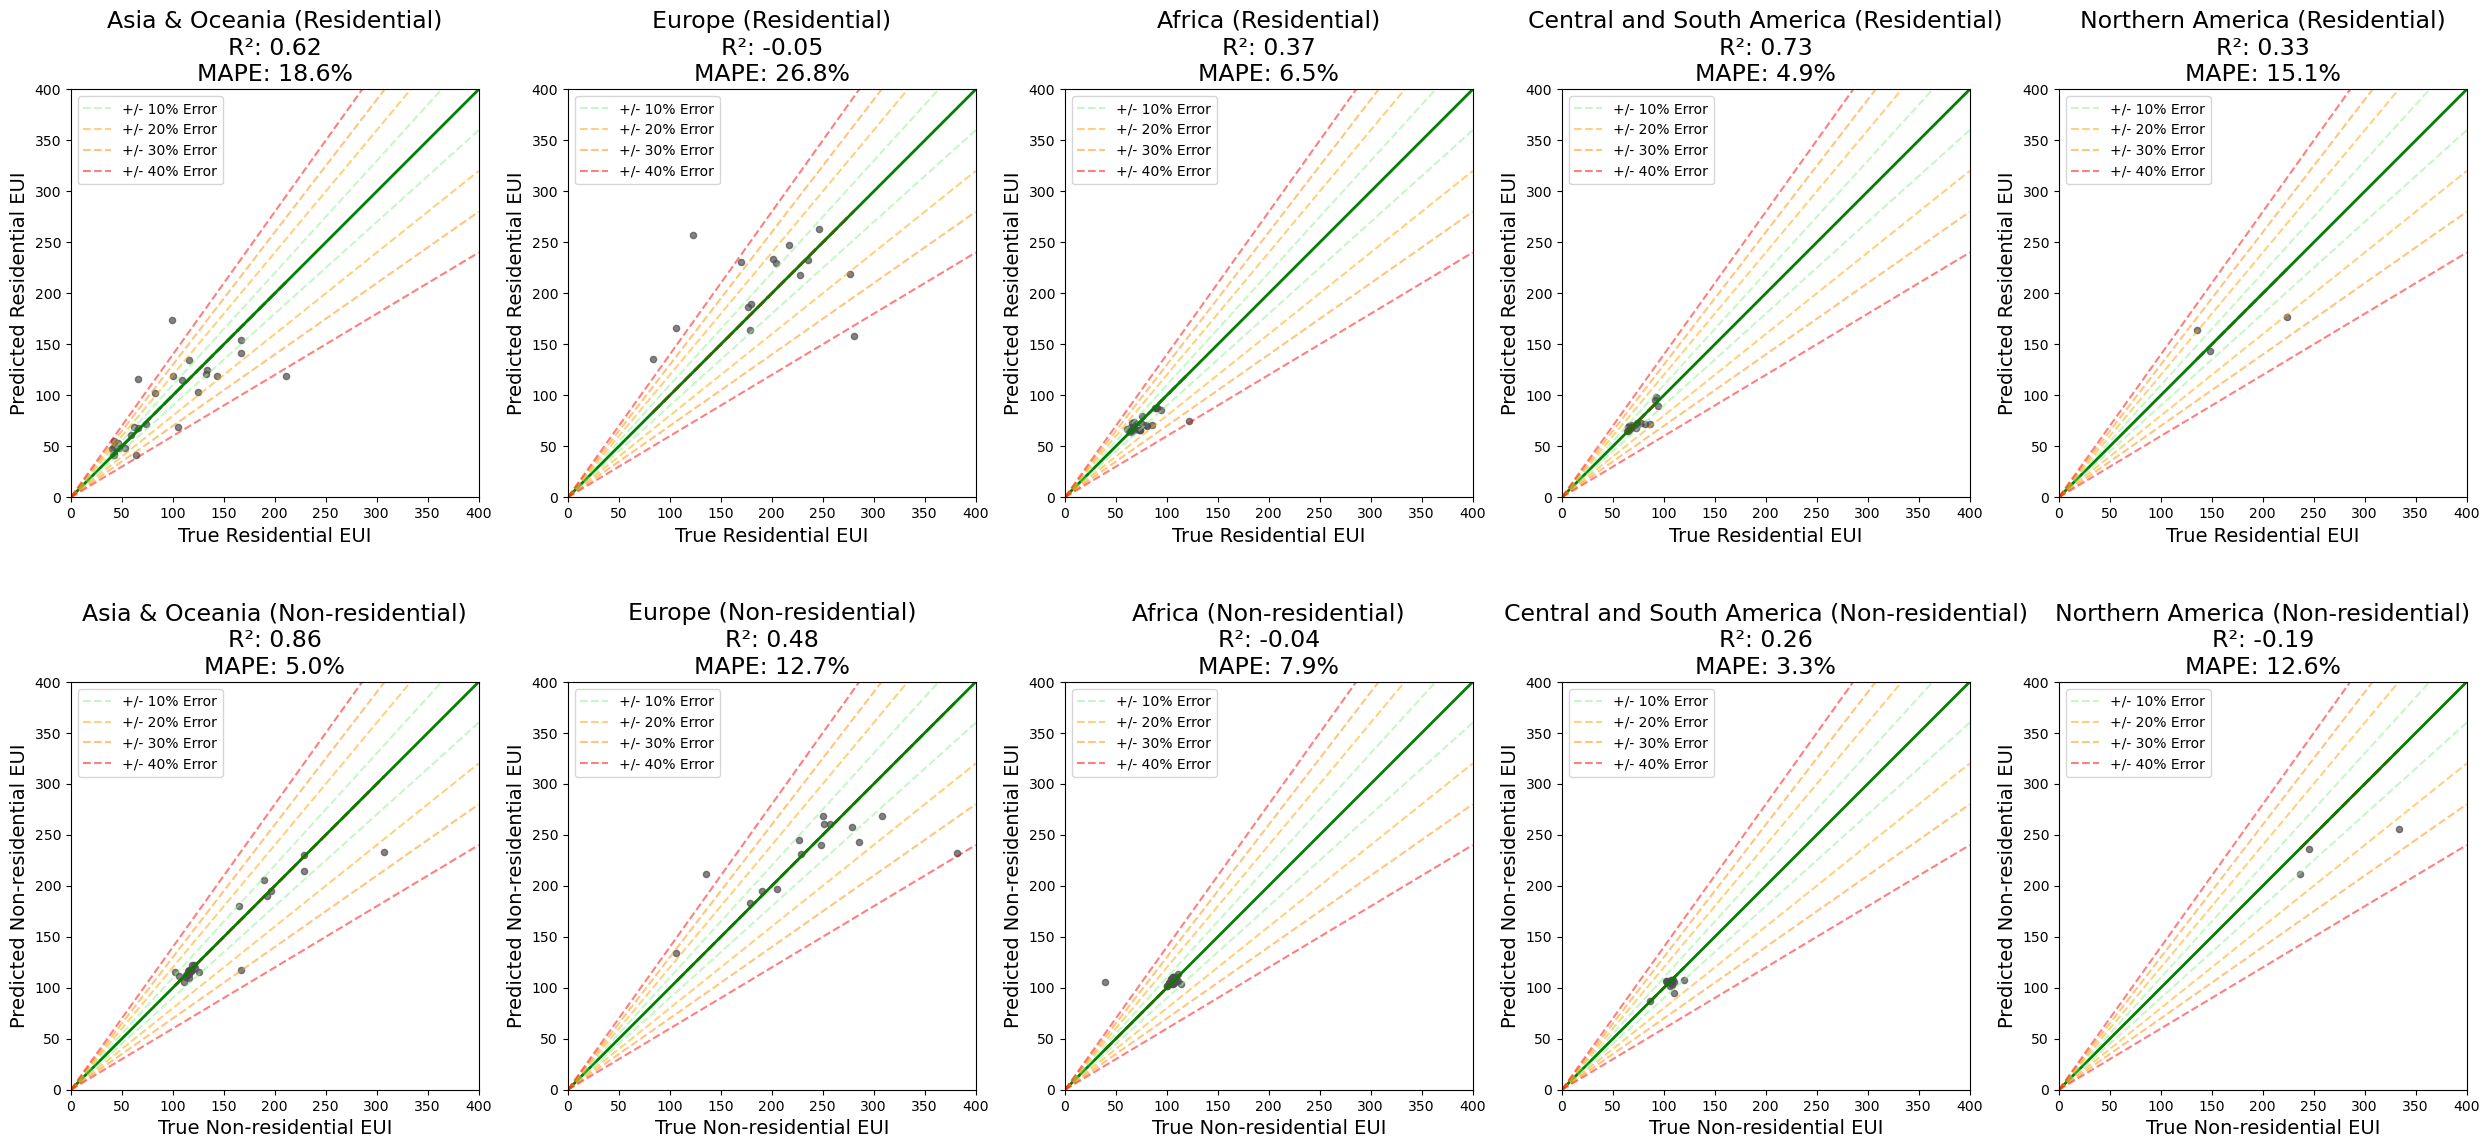

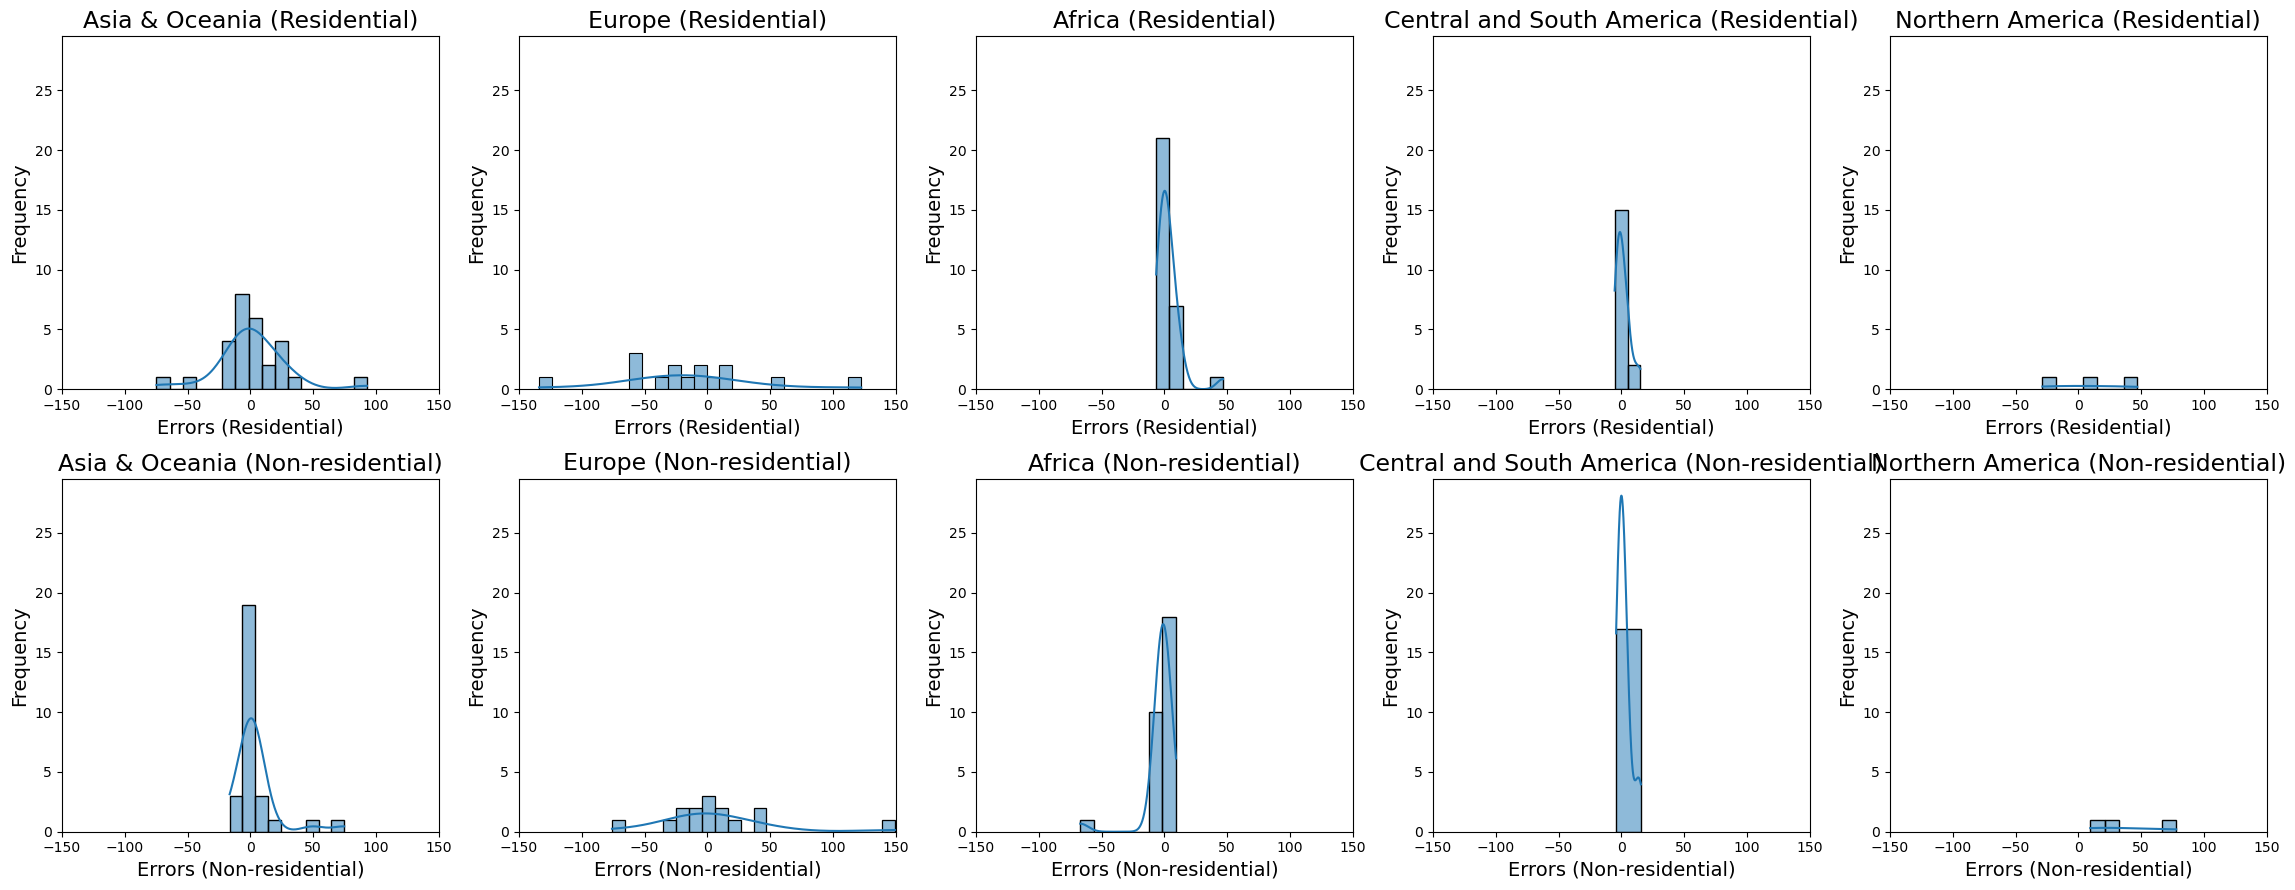

In [9]:
# Within-domain
model_rf_within = RandomForestRegressor(**rf_params)
results_rf_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_rf_within, 
    save_path='../figures/model_plots/rf_within_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_within,
    save_path='../figures/model_plots/rf_within_domain_error_distribution.png')

### Random Forest - Cross Domain

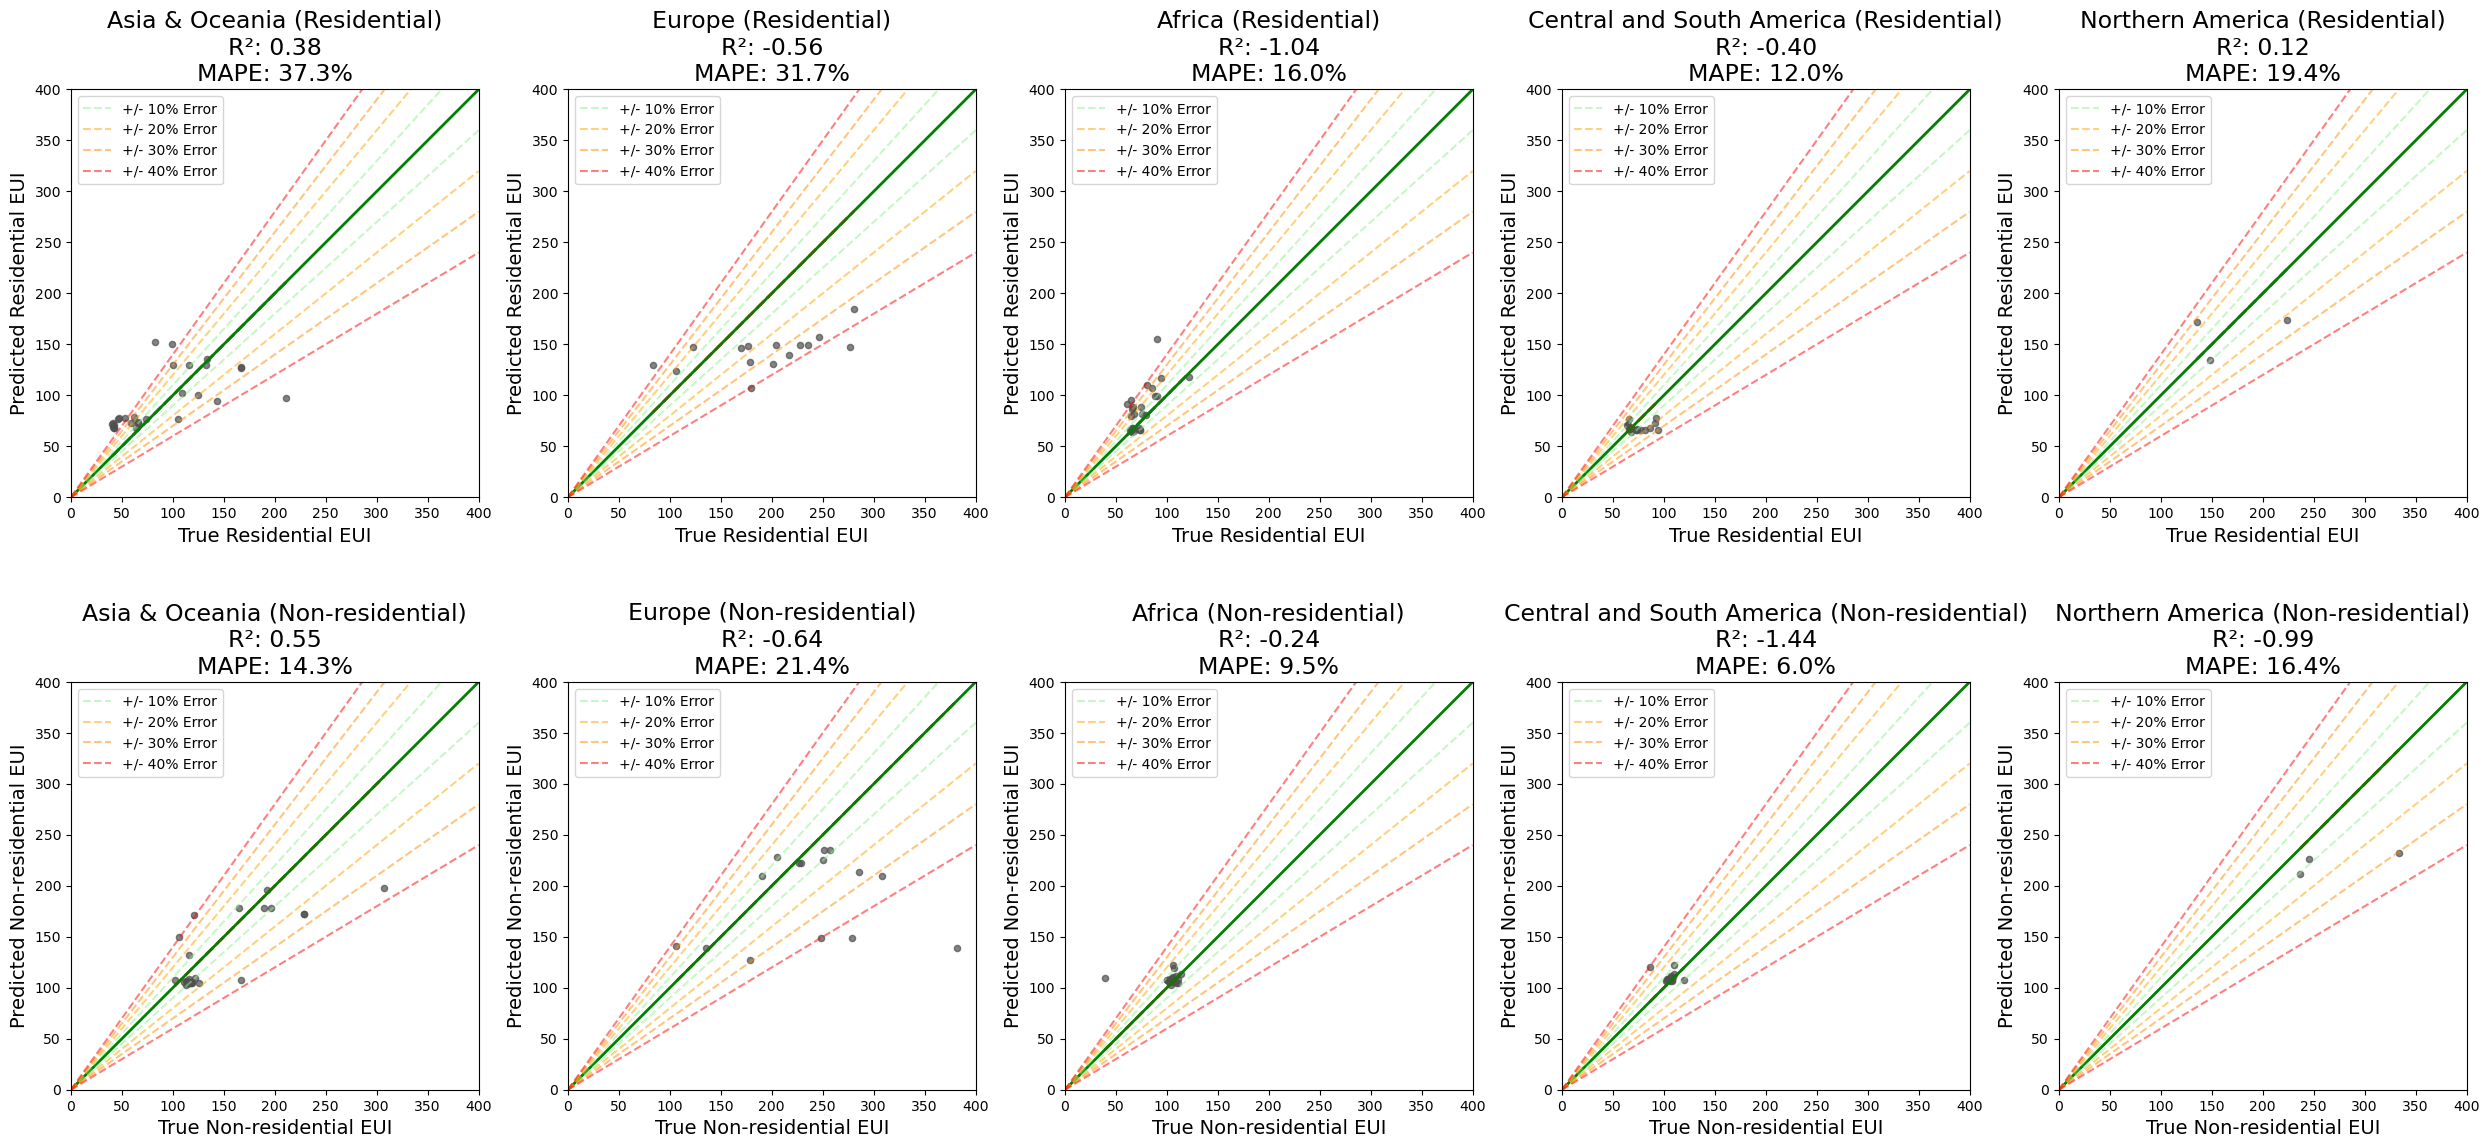

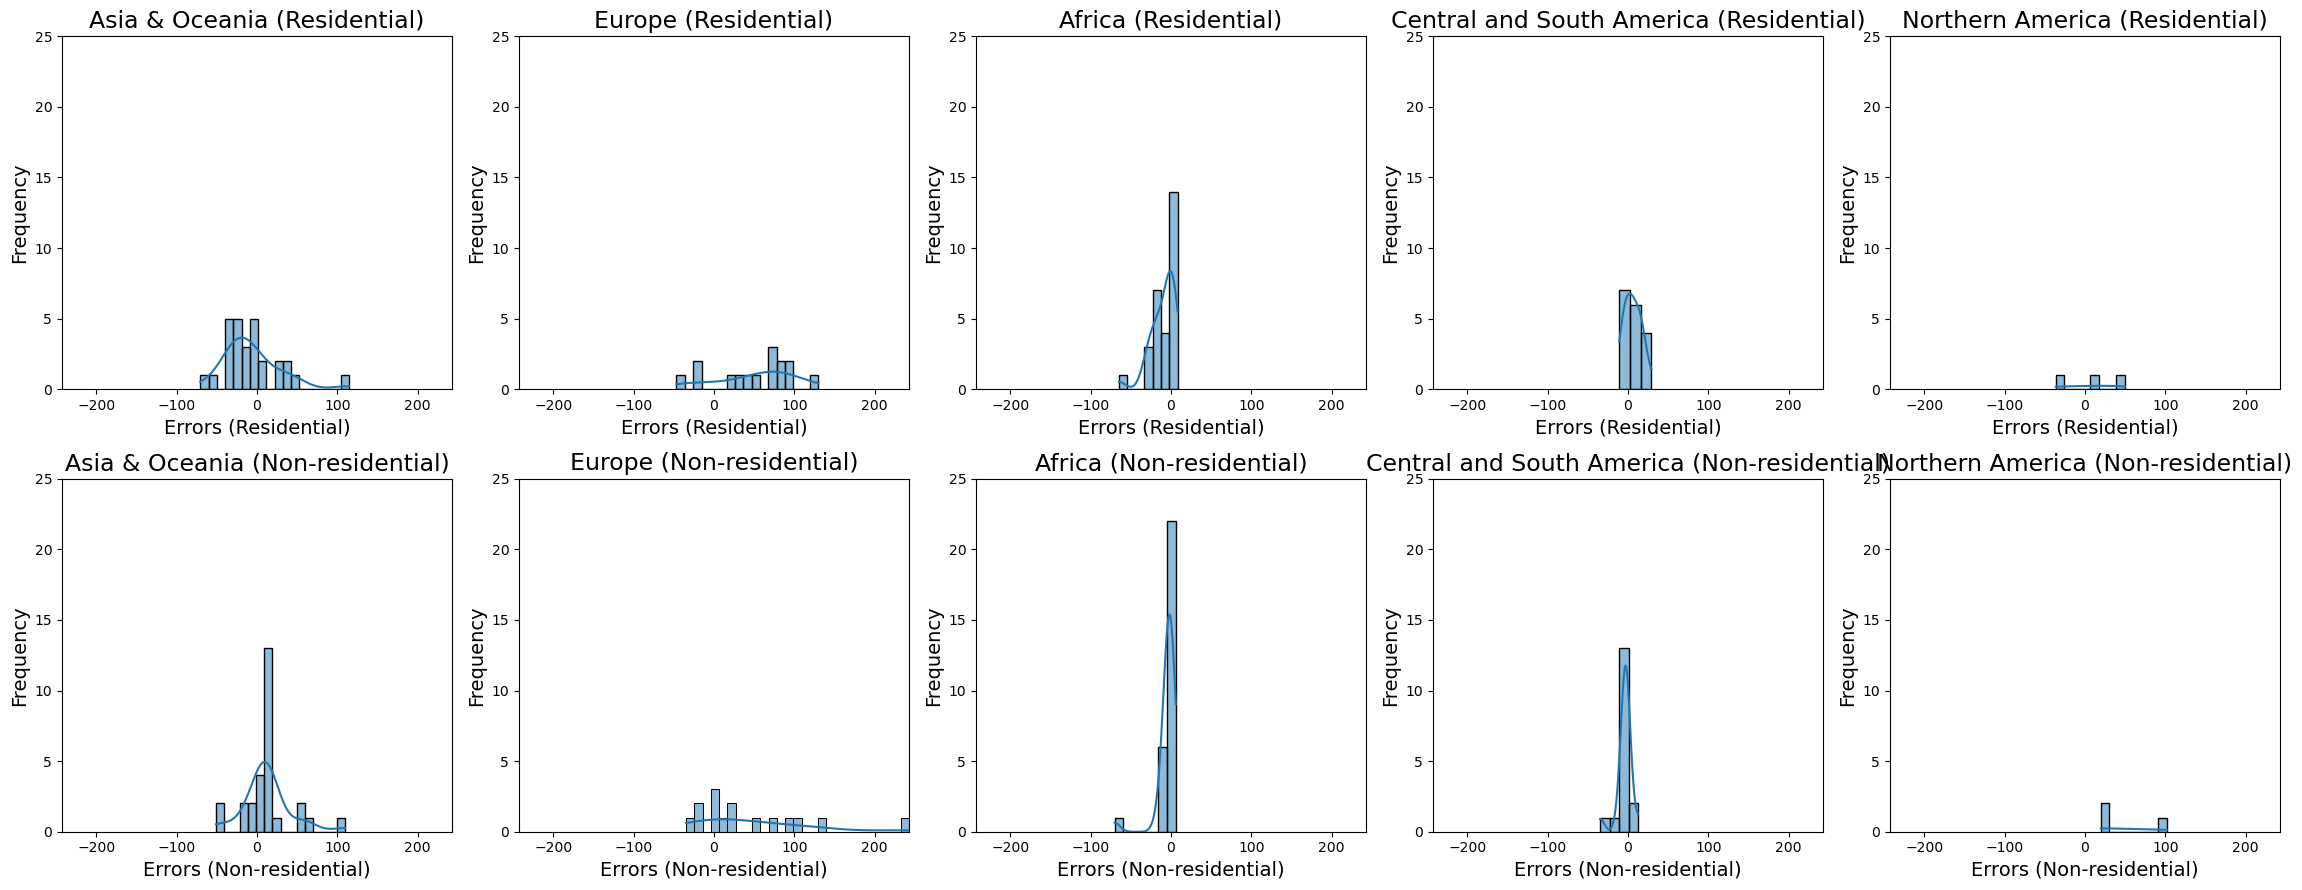

In [10]:
# Cross-domain
model_rf_cross = RandomForestRegressor(**rf_params)
results_rf_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_rf_cross,
    save_path='../figures/model_plots/rf_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_cross,
    save_path='../figures/model_plots/rf_cross_domain_error_distribution.png')

### Random Forest - All Domain

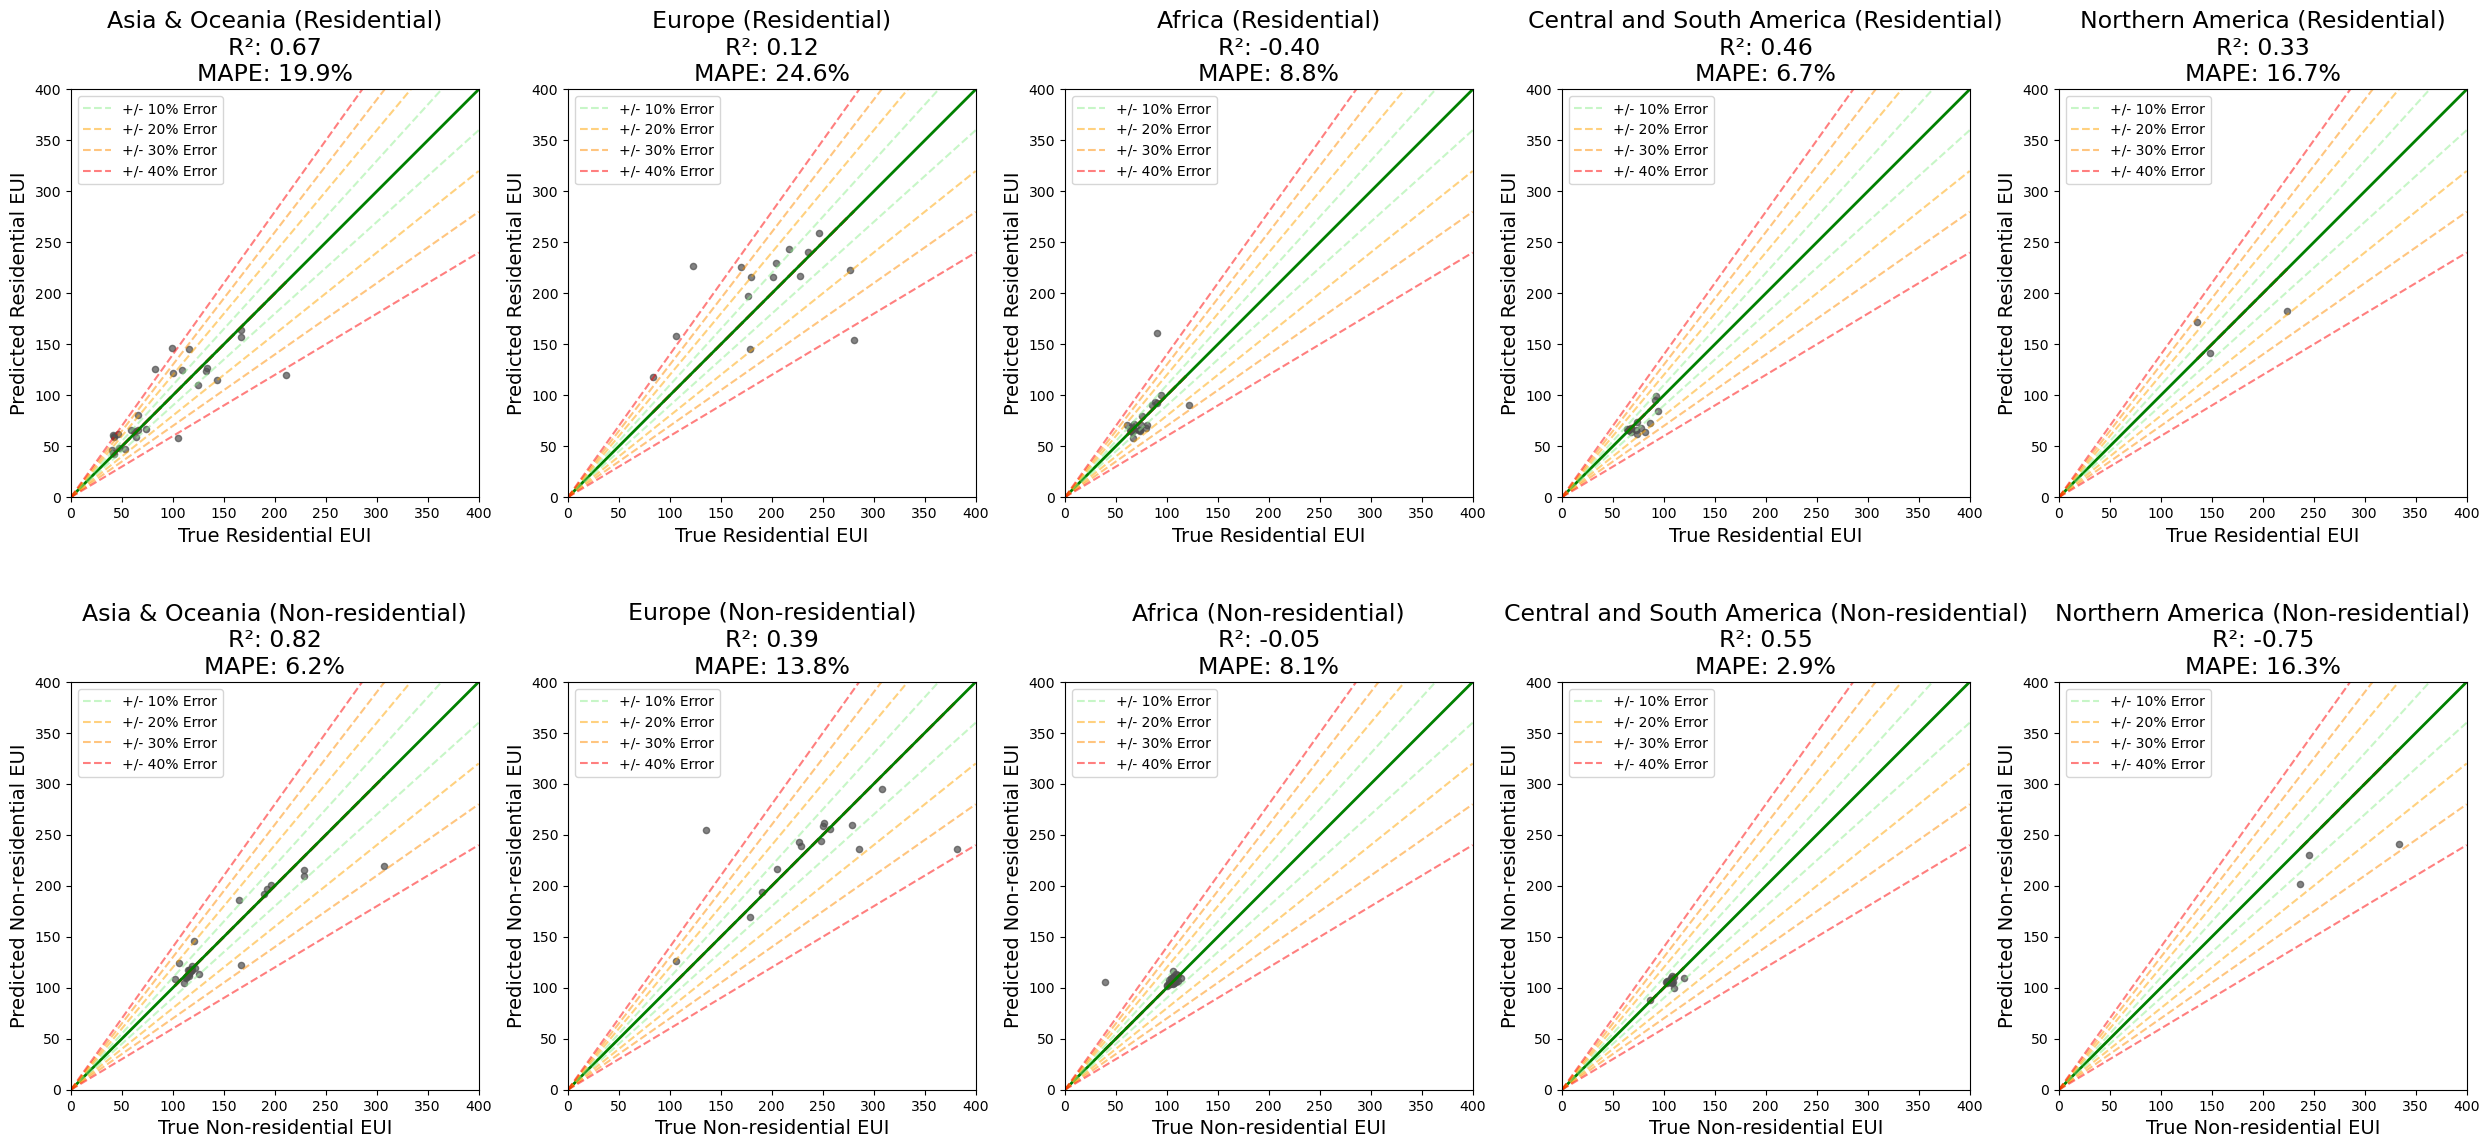

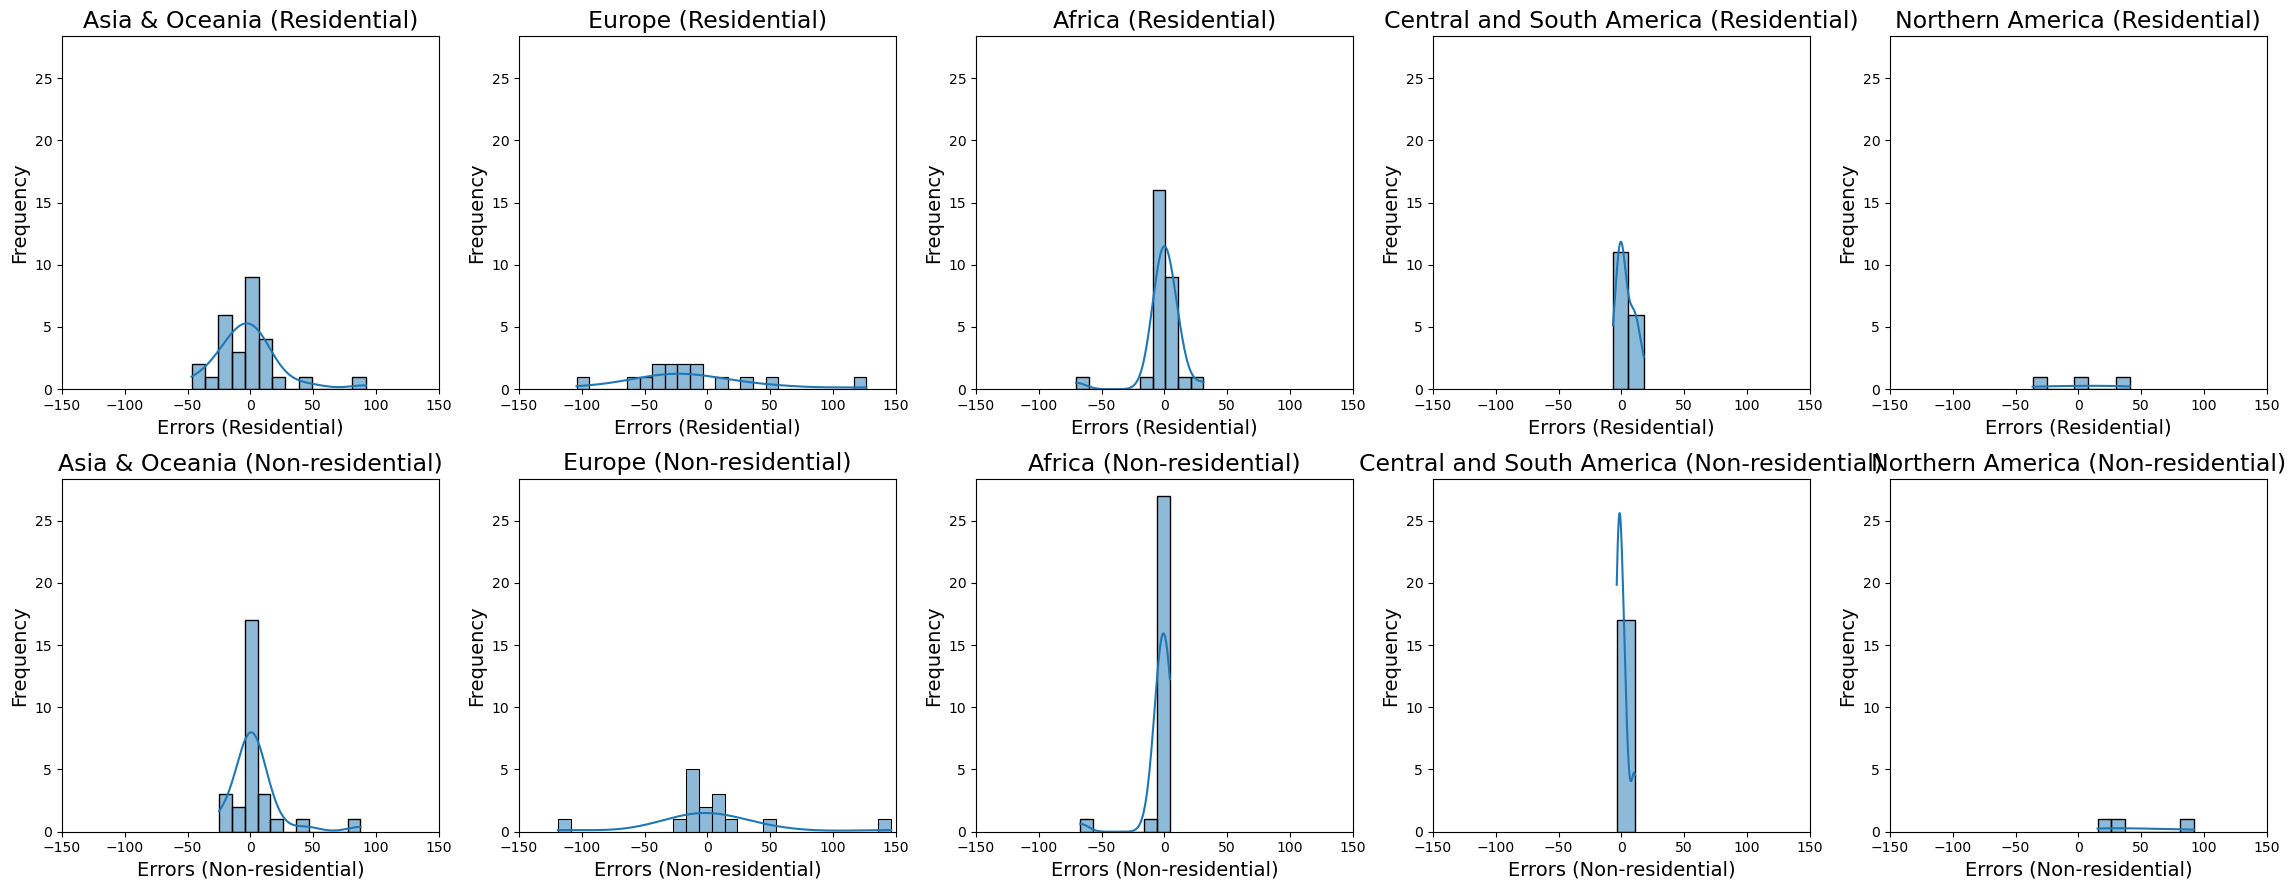

In [11]:
# All-domain
model_rf_all = RandomForestRegressor(**rf_params)
results_rf_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_rf_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_rf_all,
    save_path='../figures/model_plots/rf_all_domain_eui_predictions.png')

create_error_distribution_plots(results_rf_all,
    save_path='../figures/model_plots/rf_all_domain_error_distribution.png')

In [12]:
RFModel = lambda: RandomForestRegressor(**rf_params)
rf_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=RFModel,  
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in rf_params.items())
)
rf_detailed_results['Model'] = 'RandomForestRegressor'

rf_average_results = calculate_average_metrics(rf_detailed_results).reset_index()
rf_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,"n_estimators=10, max_depth=10, min_samples_spl...","hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,8.30,0.276,1006.166,26.270,16.609,7.96
1,Non-residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,"n_estimators=10, max_depth=10, min_samples_spl...","hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,13.52,-0.551,2452.131,40.463,27.873,13.76
2,Non-residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,"n_estimators=10, max_depth=10, min_samples_spl...","hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,9.46,0.193,1318.382,29.392,19.087,8.98
3,Residential EUI (kWh/m2/year),within_domain,RandomForestRegressor,"n_estimators=10, max_depth=10, min_samples_spl...","hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,14.38,0.399,1049.850,26.620,19.300,14.12
4,Residential EUI (kWh/m2/year),cross_domain,RandomForestRegressor,"n_estimators=10, max_depth=10, min_samples_spl...","hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,23.28,-0.302,1604.910,34.650,29.138,22.56
5,Residential EUI (kWh/m2/year),all_domain,RandomForestRegressor,"n_estimators=10, max_depth=10, min_samples_spl...","hdd_total_year, Subnational HDI, Income index,...",HDD | HDI | Income | Temp | Dew | Long_Cos | L...,15.34,0.237,953.923,26.714,19.865,14.94


In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
rf_detailed_results.to_csv(f'../results/{timestamp}_rf_detailed_results.csv')
rf_average_results.to_csv(f'../results/{timestamp}_rf_average_results.csv')

# 